## Important parameters
<br>xt_ocean: longitude, length 3600
<br>yt_ocean: latitude, length 1500
<br> [mind map](https://miro.com/app/board/o9J_lM4N1Pg=/?fromRedirect=1)

In [1]:
import netCDF4 as nc4
import keras
import xarray,numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from tensorflow.keras import layers

# Load data

In [2]:
file_path =['C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_02.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_03.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_04.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_05.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_06.nc')
ds = nc4.MFDataset(file_path)
eta_t = ds.variables['eta_t'][:]
eta_t_numpy = np.array(eta_t)
eta_t_numpy = np.nan_to_num(eta_t_numpy)

# check input shape
eta_t_numpy.shape

(182, 1500, 3600)

# Preprocessing

In [3]:
def fix_missing_value(input_data):
    """
    fixed missing values with 0
    """
    for i in range(0,len(input_data)):
        arr = input_data[i]
        arr[arr == -32768] = 0

In [4]:
def normalize_matrix(matrix):
    """
    Normalize the input
    
    """
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

In [5]:
import math
lat = 128 # chunk size
long = 128 # chunk size
def split_array(input_data, lat, long):
    """
    Split the whole 3600*1500 array into smaller chunks.
    Padding with zeros to make the array be divisible by chunk size.
    
    Args:
        input_data: data of a single day from a eta_t instance
        lat: chunk size
        long: chunk size
    """
    pad_cols = math.ceil(3600/long)*long - 3600 # number of zero columns adding to the right
    pad_rows = math.ceil(1500/lat)*lat - 1500 # number of zero rows adding to the bottom
    

    input_data=np.pad(input_data,((0,pad_rows),(0,pad_cols)), 'constant',constant_values=(0,0)) # padding with zeros, right & bottom
    
    l = np.array_split(input_data,len(input_data)/lat,axis=0)
    input_data_split = []
    for i in range(len(l)):
        dd = np.array_split(l[i],len(input_data[0])/long,axis=1)
        input_data_split += dd
    input_data_split = np.array(input_data_split)
    return input_data_split

In [6]:
def preprocess(eta_t_numpy, lat, long, region_index): 
    """
    Input a eta_t instance, return a particular region in the splitted array.
    
    Args:
        eta_t_numpy: one eta_t instance in numpy format
        lag: chunk size
        long: chunk size
        region_index: the particular region interested
    Return:
        A numpy array in shape (size, lat, long)
    """
    input_data_split = []
    for i in range(len(eta_t_numpy)):
        input_data = eta_t_numpy[i,:,:]
        fix_missing_value(input_data) # replace missing value

        normalize_matrix(input_data) # normalize

        input_data_split.append(split_array(input_data, lat, long)[region_index])
    return np.array(input_data_split)

In [7]:
input_data_split= preprocess(eta_t_numpy, lat, long, 100)

In [8]:
# save to a file
np.save('128x128_6months',input_data_split)

In [9]:
input_data_split.shape

(182, 128, 128)

# split train set & validation set

In [10]:
train_set, test_set = train_test_split(input_data_split, test_size=0.33)
train_set.shape

(121, 128, 128)

# Autoencoder

In [11]:
lat = 128 # chunk size
long = 128 # chunk size

input_img = keras.Input(shape=(lat, long,1))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu',strides=(1,1), padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2DTranspose(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 4)         292       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 4)         148       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 8)         296   

In [12]:
history = autoencoder.fit(train_set, train_set,
                epochs=50, validation_data=(test_set, test_set))

Epoch 1/50
4/4 [==============================] - 3s 752ms/step - loss: 0.0356 - val_loss: 0.0348
Epoch 2/50
4/4 [==============================] - 1s 158ms/step - loss: 0.0349 - val_loss: 0.0341
Epoch 3/50
4/4 [==============================] - 1s 156ms/step - loss: 0.0348 - val_loss: 0.0331
Epoch 4/50
4/4 [==============================] - 1s 157ms/step - loss: 0.0332 - val_loss: 0.0308
Epoch 5/50
4/4 [==============================] - 1s 150ms/step - loss: 0.0306 - val_loss: 0.0285
Epoch 6/50
4/4 [==============================] - 1s 153ms/step - loss: 0.0283 - val_loss: 0.0275
Epoch 7/50
4/4 [==============================] - 1s 156ms/step - loss: 0.0272 - val_loss: 0.0274
Epoch 8/50
4/4 [==============================] - 1s 149ms/step - loss: 0.0270 - val_loss: 0.0263
Epoch 9/50
4/4 [==============================] - 1s 149ms/step - loss: 0.0257 - val_loss: 0.0244
Epoch 10/50
4/4 [==============================] - 1s 151ms/step - loss: 0.0238 - val_loss: 0.0217
Epoch 11/50
4/4 [==

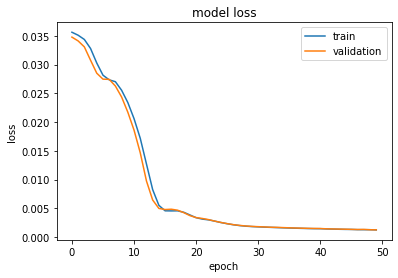

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [14]:
decoded_data = autoencoder.predict(np.array([test_set[10]]))

In [1]:
import matplotlib.pyplot as plt
plt.imshow(test_set[10],cmap='hot')
plt.show()
plt.imshow(decoded_data[0,:,:,0],cmap='hot')
plt.show()

NameError: name 'test_set' is not defined

## bottleneck size 32 x 32 x n, where n = 1,2,4,8

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 2)       20        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 1)         19        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 1)         10        
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 2)         20  

Epoch 34/100
4/4 [==============================] - 0s 125ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 35/100
4/4 [==============================] - 0s 129ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 36/100
4/4 [==============================] - 0s 134ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 37/100
4/4 [==============================] - 0s 122ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 38/100
4/4 [==============================] - 0s 129ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 39/100
4/4 [==============================] - 0s 129ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 40/100
4/4 [==============================] - 0s 123ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 41/100
4/4 [==============================] - 0s 125ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 42/100
4/4 [==============================] - 0s 127ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 43/100
4/4 [==============================] - 0s 125ms/step - loss: 0.0034 - val_loss: 0.0035


Epoch 1/100
4/4 [==============================] - 1s 205ms/step - loss: 0.0359 - val_loss: 0.0343
Epoch 2/100
4/4 [==============================] - 1s 153ms/step - loss: 0.0348 - val_loss: 0.0330
Epoch 3/100
4/4 [==============================] - 1s 156ms/step - loss: 0.0331 - val_loss: 0.0306
Epoch 4/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0301 - val_loss: 0.0275
Epoch 5/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0274 - val_loss: 0.0270
Epoch 6/100
4/4 [==============================] - 1s 149ms/step - loss: 0.0269 - val_loss: 0.0263
Epoch 7/100
4/4 [==============================] - 1s 148ms/step - loss: 0.0259 - val_loss: 0.0245
Epoch 8/100
4/4 [==============================] - 1s 155ms/step - loss: 0.0243 - val_loss: 0.0233
Epoch 9/100
4/4 [==============================] - 1s 157ms/step - loss: 0.0232 - val_loss: 0.0220
Epoch 10/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0215 - val_loss: 0.0201
Epoch 11/

Epoch 82/100
4/4 [==============================] - 1s 167ms/step - loss: 7.6904e-04 - val_loss: 7.7498e-04
Epoch 83/100
4/4 [==============================] - 1s 151ms/step - loss: 7.6064e-04 - val_loss: 7.6511e-04
Epoch 84/100
4/4 [==============================] - 1s 152ms/step - loss: 7.4683e-04 - val_loss: 7.5343e-04
Epoch 85/100
4/4 [==============================] - 1s 156ms/step - loss: 7.4109e-04 - val_loss: 7.3960e-04
Epoch 86/100
4/4 [==============================] - 1s 167ms/step - loss: 7.1864e-04 - val_loss: 7.3048e-04
Epoch 87/100
4/4 [==============================] - 1s 167ms/step - loss: 7.1069e-04 - val_loss: 7.1508e-04
Epoch 88/100
4/4 [==============================] - 1s 160ms/step - loss: 6.9882e-04 - val_loss: 7.1189e-04
Epoch 89/100
4/4 [==============================] - 1s 162ms/step - loss: 6.9867e-04 - val_loss: 6.9575e-04
Epoch 90/100
4/4 [==============================] - 1s 162ms/step - loss: 6.8021e-04 - val_loss: 6.8710e-04
Epoch 91/100
4/4 [==========

Epoch 46/100
4/4 [==============================] - 1s 222ms/step - loss: 6.8946e-04 - val_loss: 7.0501e-04
Epoch 47/100
4/4 [==============================] - 1s 223ms/step - loss: 6.8215e-04 - val_loss: 6.7519e-04
Epoch 48/100
4/4 [==============================] - 1s 224ms/step - loss: 6.5966e-04 - val_loss: 6.5605e-04
Epoch 49/100
4/4 [==============================] - 1s 223ms/step - loss: 6.3565e-04 - val_loss: 6.4154e-04
Epoch 50/100
4/4 [==============================] - 1s 224ms/step - loss: 6.2099e-04 - val_loss: 6.2760e-04
Epoch 51/100
4/4 [==============================] - 1s 220ms/step - loss: 6.1150e-04 - val_loss: 6.1412e-04
Epoch 52/100
4/4 [==============================] - 1s 220ms/step - loss: 5.9773e-04 - val_loss: 6.0141e-04
Epoch 53/100
4/4 [==============================] - 1s 222ms/step - loss: 5.8636e-04 - val_loss: 5.9042e-04
Epoch 54/100
4/4 [==============================] - 1s 224ms/step - loss: 5.7190e-04 - val_loss: 5.7819e-04
Epoch 55/100
4/4 [==========

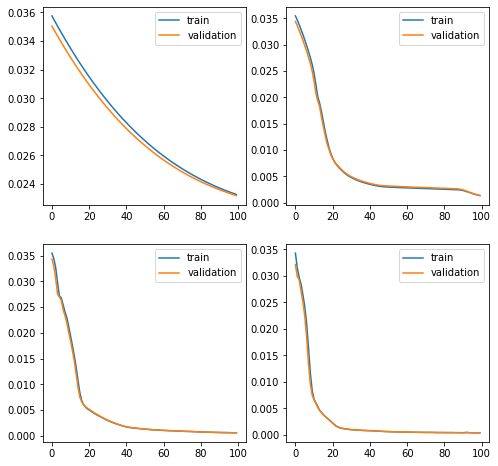

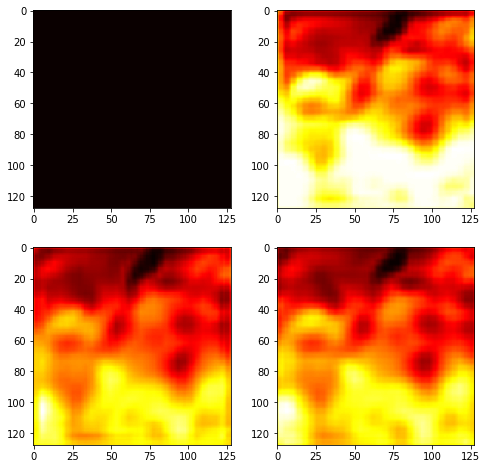

In [16]:
input_img = keras.Input(shape=(lat, long,1))

fig1 = plt.figure(figsize=(8,8)) # mse loss
fig2 = plt.figure(figsize=(8,8)) # image

for i in range(1,5):
    x = layers.Conv2D(math.pow(2,i), (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(math.pow(2,i-1), (3, 3), activation='relu',strides=(1,1), padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2DTranspose(math.pow(2,i-1), (3, 3), activation='relu', padding='same')(encoded)
    x = layers.Conv2DTranspose(math.pow(2,i), (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((4, 4))(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    history = autoencoder.fit(train_set, train_set,
                epochs=100, validation_data=(test_set, test_set))

    decoded_data = autoencoder.predict(np.array([test_set[10]]))
    
    ax1 = fig1.add_subplot(2,2,i)
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train', 'validation'], loc='upper right')
    
    ax2 = fig2.add_subplot(2,2,i)
    ax2.imshow(decoded_data[0,:,:,0],cmap='hot')

## bottleneck size n x n x 4, where n = 32, 16, 8 or 4

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 4)         292       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 32, 32, 4)         148       
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 32, 32, 8)         296 

4/4 [==============================] - 0s 128ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 23/100
4/4 [==============================] - 1s 128ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 24/100
4/4 [==============================] - 1s 131ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 25/100
4/4 [==============================] - 0s 128ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 26/100
4/4 [==============================] - 0s 131ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 27/100
4/4 [==============================] - 0s 129ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 28/100
4/4 [==============================] - 0s 130ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 29/100
4/4 [==============================] - 0s 128ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 30/100
4/4 [==============================] - 1s 135ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 31/100
4/4 [==============================] - 0s 134ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 32/100


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 4)         292       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 4)           148       
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 8, 8, 8)           296 

4/4 [==============================] - 1s 138ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 27/100
4/4 [==============================] - 1s 133ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 28/100
4/4 [==============================] - 1s 133ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 29/100
4/4 [==============================] - 1s 140ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 30/100
4/4 [==============================] - 1s 140ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 31/100
4/4 [==============================] - 1s 134ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 32/100
4/4 [==============================] - 1s 137ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 33/100
4/4 [==============================] - 1s 140ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 34/100
4/4 [==============================] - 1s 139ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 35/100
4/4 [==============================] - 0s 130ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 36/100


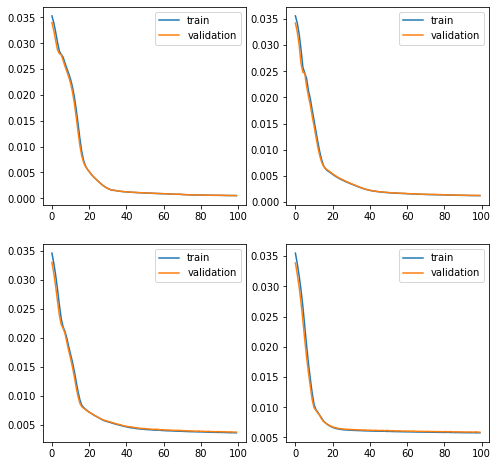

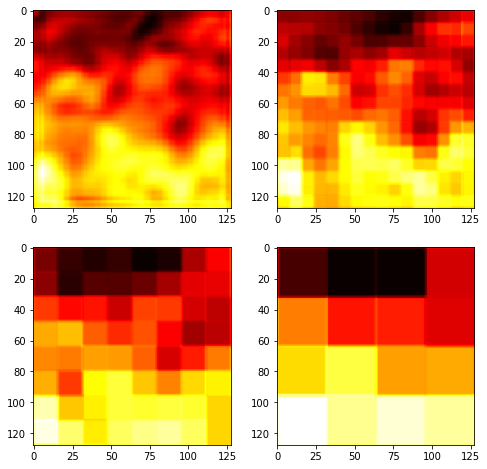

In [17]:
fig3 = plt.figure(figsize=(8,8)) # mse loss
fig4 = plt.figure(figsize=(8,8)) # image

for i in range(1,5):
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(4, (3, 3), activation='relu',strides=(1,1), padding='same')(x)
    encoded = layers.MaxPooling2D((int(math.pow(2,i)),int(math.pow(2,i))), padding='same')(x)

    x = layers.Conv2DTranspose(4, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((int(math.pow(2,i+1)),int(math.pow(2,i+1))))(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    history = autoencoder.fit(train_set, train_set,
                epochs=100, validation_data=(test_set, test_set))

    decoded_data = autoencoder.predict(np.array([test_set[10]]))
    
    ax1 = fig3.add_subplot(2,2,i)
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train', 'validation'], loc='upper right')
    
    ax2 = fig4.add_subplot(2,2,i) 
    ax2.imshow(decoded_data[0,:,:,0],cmap='hot')